In [1]:
from my_weapon import *
from collections import defaultdict

In [21]:
tweets = {}                     # tweet 内容
tweets_url = {}                 # tweets对应的url
url_tweetid = defaultdict(list) # url对应的tweets

# 载入原始fake_news数据
for line in tqdm(open("data/tweets_fake.txt")):
    d = json.loads(line)
    if "final_url" in d:
        tweet_id = int(d["tweet_id"])
        tweets[tweet_id] = d
        url = d["final_url"].lower()
        tweets_url[tweet_id] = url
        url_tweetid[url].append({"id": tweet_id, "dt": d["datetime_EST"], "user_id": d["user_id"]})
            
# with open("data/tweets_fake.txt", "w") as f:
#     for v in tweets.values():
#         f.write(json.dumps(v, ensure_ascii=False) + "\n")

print("存在url of fake news的tweet：", len(tweets))
print("url集合的量：", len(url_tweetid))

2338079it [00:25, 92175.51it/s]

存在url of fake news的tweet： 2338079
url集合的量： 189621


In [31]:
from SQLite_handler import find_tweet, find_user

find_tweet(742417158429233152)
# find_user(743166519157227520)

{'tweet_id': 742417158429233152,
 'query_id': 0,
 'filename_id': 53,
 'datetime_EST': '2016-06-13 13:03:38',
 'user_id': 1226167963,
 'text': "@TheRalphRetort #WTF Saudi Arabia Has Funded 20% Of Hillary's Presidential Campaign, Saudi Crown Prince Claims https://t.co/3UCj9G0HGn",
 'place': None,
 'source_url_id': 2,
 'source_content_id': 2}

In [31]:
# 利用转发网络扩充谣言数据

# tweet -> retwtweet
fake_retweets_links = json.load(open("data/retweet_network_fake.json"))
# fake_tweets = set()

for tweet_id, retweetd_id in tqdm(fake_retweets_links.items()):
    tweet_id, retweetd_id = int(tweet_id), int(retweetd_id)
#     fake_tweets.add(tweet_id)
#     fake_tweets.add(retweetd_id)
    url = tweets_url[int(retweetd_id)] # 得到 转发消息 的URL
    
    tweets_url[tweet_id] = url
    
    if tweet_id not in tweets:
        d = find_tweet(tweet_id)
        url_tweetid[url].append({"id": tweet_id, "dt": d["datetime_EST"]})
    

# print("fake spread的节点个数：", len(fake_tweets))

100%|██████████| 1663428/1663428 [03:10<00:00, 8711.92it/s]

fake spread的节点个数： 1930939


In [32]:
import pandas as pd

data = pd.Series([len(v) for v in url_tweetid.values()])
data.describe()

count    189621.000000
mean         13.598974
std          93.549382
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max       13367.000000
dtype: float64

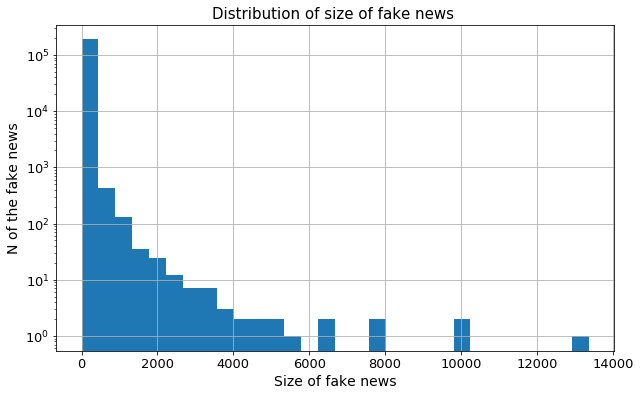

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def get_cdf_pdf(data, mini, maxi, step, norm=True):
    x = [float(i) for i in np.arange(mini, maxi, step)]
    cdf = [0] * len(x)
    pdf = [0] * len(x)
    count = 0
    for d in data:
        d = float(d)
        if d < mini or d > maxi:
            continue
        count += 1
        for i in range(len(x)):
            if i == (len(x) - 1) and d >= x[i]:
                pdf[i] += 1
            elif d >= x[i] and d < x[i+1]:
                pdf[i] += 1

            if d >= x[i]:
                cdf[i] += 1

    if norm:
        cdf = [c / count for c in cdf]
        pdf = [p / count for p in pdf]

    return x, cdf, pdf


# x, cdf, pdf = get_cdf_pdf(data, 0, 15000, 100)
plt.figure(figsize=(10, 6))
data.hist(bins=30)
plt.title('Distribution of size of fake news ', fontsize=15)
plt.ylabel('N of the fake news', fontsize=14)
plt.xlabel('Size of fake news', fontsize=14)
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.yscale("log")
plt.savefig('fig/distribution_size_fake_news.pdf', dpi=300)
plt.show()
plt.close()


In [35]:
url_tweetid["https://thepoliticalinsider.com/clinton-foundation-obama-made-major-move-keep-prison-leaked/"]

[{'id': 763804618547572736, 'dt': '2016-08-11 13:29:46'},
 {'id': 763804883212505088, 'dt': '2016-08-11 13:30:49'},
 {'id': 763993324285861893, 'dt': '2016-08-12 01:59:37'},
 {'id': 764000152042414084, 'dt': '2016-08-12 02:26:45'},
 {'id': 764028274485829633, 'dt': '2016-08-12 04:18:30'},
 {'id': 764051322282782721, 'dt': '2016-08-12 05:50:05'},
 {'id': 764055110414536704, 'dt': '2016-08-12 06:05:08'},
 {'id': 765316378341482496, 'dt': '2016-08-15 17:36:58'},
 {'id': 765643842888437760, 'dt': '2016-08-16 15:18:11'}]

In [79]:
# 先按照每个谣言涉及到的tweet数量进行排序

sorted_url = sorted(url_tweetid.items(), key=lambda d: len(d[1]), reverse=True)

with open("data/id_len_url.txt", "w") as f:
    for i, v in enumerate(sorted_url):
        f.write("{}\t{}\t{}\n".format(i, len(v[1]), v[0]))

---

以上的分析找到了每个URL传播的过程，然后我要分析哪些是原创的tweet，方法就是判断是不是转发的微博，转发的微博就是在转发网络的keys中～

In [80]:
retweeting_tweets = set([int(k) for k in fake_retweets_links.keys()])

# 下面是非常关键的数据！

url -> tweets

In [3]:
# save

# json.dump(url_tweets, open("data/url_tweets.txt", "w"), indent=2)

url_tweets = json.load(open("data/url_tweets.json"))
# del url_tweets[0] # 第一条too general 目前的数据已经删除

# starters_cnt = 0
# first_users = set()
# starter_users = set()

# for fake in url_tweets:
#     for j, t in enumerate(fake["tweets"]):
#         if t["origin"]:
#             starters_cnt += 1
#             starter_users.add(t["user_id"])
#             if j == 0:
#                 first_users.add(t["user_id"])
    
# len(url_tweets), starters_cnt, len(first_users), len(starter_users)

- 189620条谣言URL, 914272条初始推特；
- 25212个第一条谣言的用户, 88215个发初始推特的用户；

### 专门针对用户的分析，放到analyze_users.ipy中～

In [4]:
from urllib.parse import urlparse


def get_day(dt):
    return pendulum.parse(dt).format("YYYY-MM-DD 00:00:00")
    
    
def get_hour(dt):
    return pendulum.parse(dt).format("YYYY-MM-DD HH:00:00")
    

def cal_ts_day(dts):
    start = get_day(dts[0])
    end = get_day(dts[-1])
    rng = pd.date_range(start, end, freq='D')
    ts = pd.Series(0, rng)
    for dt in dts:
        now = get_day(dt)
        ts[now] += 1
    return ts


def cal_ts_48hours(dts):
    start = get_hour(dts[0])
    rng = pd.date_range(start, periods=48, freq="H")
    ts = pd.Series(0, rng)
    for dt in dts:
        now = get_hour(dt)
        if now in ts:
            ts[now] += 1
    return ts
    
    
def plot_day_v2_starter(i, url, sorted_dts, sorted_dts2, save=False):
    """
    包含了两条线！
    """

    plt.figure(figsize=(10, 6))
    ts = cal_ts_day(sorted_dts)
    ts.plot()
    
    ts2 = cal_ts_day(sorted_dts2)
    ts2.plot()
    
    # configure
    plt.ylabel('N of tweets with this fake news', fontsize=15)
    plt.xticks(fontsize=11); plt.yticks(fontsize=11)
#     plt.xlabel('$Date$', fontsize=15)
#     plt.title(url)
    
    if save:
        plt.savefig('fig/{}-{}-overall-spread.pdf'.format(i, url), dpi=300)
    else:
        plt.show()
    
    plt.close()


def plot_48hours_v2_starter(i, url, sorted_dts, sorted_dts2, save=False):
    """
    包含了两条线！
    """
    
#     print(url)
#     print("实际传播开始和结束时间：", sorted_dts[0], sorted_dts[-1])

    plt.figure(figsize=(10, 6))
    ts = cal_ts_48hours(sorted_dts)
    ts.plot()
    
    ts2 = cal_ts_48hours(sorted_dts2)
    ts2.plot()
    
    # configure
    plt.ylabel('N of tweets with this fake news', fontsize=15)
    plt.xticks(fontsize=11); plt.yticks(fontsize=11)
#     plt.xlabel('$Date$', fontsize=15)
#     plt.title(url)

    if save:
        plt.savefig('fig/{}-{}-first-48-hours.pdf'.format(i, url), dpi=300)
    else:
        plt.show()
        
    plt.close()


ploting ~ 1


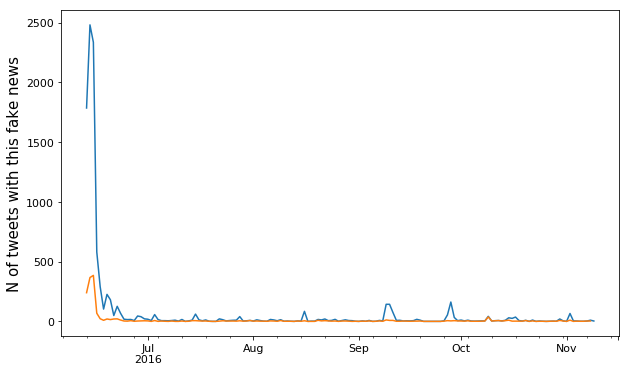

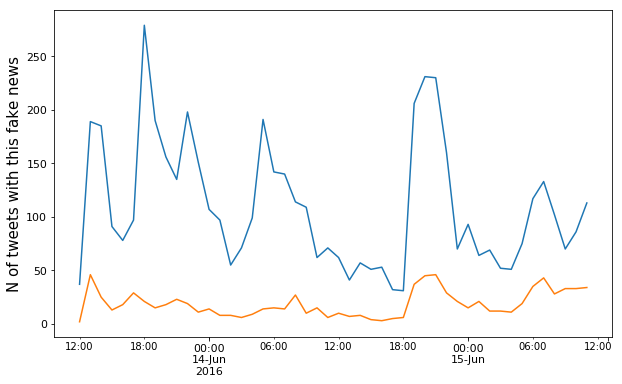

In [5]:
for i, v in enumerate(url_tweets):
    if i != 1:
        continue
        
    print("ploting ~", i)
    url = v["url"]
    tweets_list = v["tweets"]
    
    dts = [t["dt"] for t in tweets_list]

#     covert_timeseries(i, url, dts)
#     plot_first48hours(i, url, dts)
    
    dts2 = [t["dt"] for t in tweets_list if t["origin"]==True]
    plot_day_v2_starter(i, url, dts, dts2)
    plot_48hours_v2_starter(i, url, dts, dts2)

In [12]:
# 分析starter的source_content

from collections import Counter

count = []
for v in url_tweets:
    url = v["url"]
    tweet_list = v["tweets"]
    for t in tweet_list:
        if t["origin"]:
            tid = t["id"]
            d = find_source(tid)
            count.append(d)

_sum = len(count)
count = Counter(count)


Twitter Web Client - 33.09%
dlvr.it - 22.99%
Twitter for iPhone - 7.88%
Facebook - 7.87%
Twitter for Android - 5.81%
Twitter for iPad - 3.11%
Put your button on any page!  - 2.79%
Mobile Web - 2.47%
twitterfeed - 2.17%
IFTTT - 1.59%
Hootsuite - 1.01%
SocialOomph - 0.84%
Linkis.com - 0.84%
Sprout Social - 0.82%
Buffer - 0.62%
TweetDeck - 0.48%
WordPress.com - 0.44%
Rignite - 0.39%
OS X - 0.31%
Mobile Web (M5) - 0.26%


In [14]:
for k, v in count.most_common(50):
    print(k, '- {:.2%}'.format(v / _sum))

Twitter Web Client - 33.09%
dlvr.it - 22.99%
Twitter for iPhone - 7.88%
Facebook - 7.87%
Twitter for Android - 5.81%
Twitter for iPad - 3.11%
Put your button on any page!  - 2.79%
Mobile Web - 2.47%
twitterfeed - 2.17%
IFTTT - 1.59%
Hootsuite - 1.01%
SocialOomph - 0.84%
Linkis.com - 0.84%
Sprout Social - 0.82%
Buffer - 0.62%
TweetDeck - 0.48%
WordPress.com - 0.44%
Rignite - 0.39%
OS X - 0.31%
Mobile Web (M5) - 0.26%
Boost your self-promotion! - 0.23%
Put your brand on any website! - 0.21%
Your best free sharing tool! - 0.17%
PatriotJournalist - 0.16%
AboveTopSecret.com New Topics - 0.16%
iOS - 0.15%
Turn sharing to content creation - 0.14%
Twitter for Windows Phone - 0.14%
TweetCaster for Android - 0.13%
The Right Scoop - 0.12%
Zero Hedge Publisher II - 0.12%
Google - 0.12%
Linkis: turn sharing into growth - 0.11%
TheRightScoop - 0.11%
Tweet Jukebox - 0.11%
Win the Customer - 0.11%
Sociocaster App - 0.09%
Linkis - fuel your sharing! - 0.09%
Turn sharing into growth! - 0.08%
Prntly - 0.

In [213]:
# 用户分析

count = []
for k, v in url_first.items():
    count.append(v["user_id"])
_sum = len(count)
count = Counter(count)
count.most_common(20)

[(122455671, 3701),
 (4831603043, 2532),
 (60893069, 2079),
 (4496549793, 1814),
 (825501626, 1689),
 (3274720530, 1686),
 (3374126201, 1567),
 (14210021, 1451),
 (137637040, 1102),
 (18856867, 1085),
 (18208120, 1028),
 (138092553, 916),
 (634330366, 881),
 (112732163, 851),
 (359122436, 781),
 (1494835716, 775),
 (166721424, 763),
 (1246177122, 761),
 (2270900414, 744),
 (3326947147, 733)]

In [219]:
user_tweets_cnt = []
for c in count.values():
    user_tweets_cnt.append(c)
user_tweets_cnt = pd.Series(user_tweets_cnt)
user_tweets_cnt.describe()

count    25277.000000
mean         7.501721
std         51.665360
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       3701.000000
dtype: float64

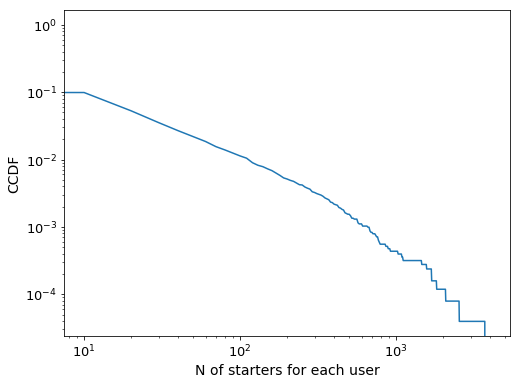

In [227]:
x, cdf, pdf = get_cdf_pdf(user_tweets_cnt, 0, 4000, 10)
plt.figure(figsize=(8, 6))
# user_tweets_cnt.hist(bins=50)
plt.plot(x, cdf)
# plt.title('Distribution of size of fake news ', fontsize=15)
plt.ylabel('CCDF', fontsize=14)
plt.xlabel('N of starters for each user', fontsize=14)
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.yscale("log")
plt.xscale("log")
plt.savefig('fig/distribution_starters.pdf', dpi=300)
plt.show()
plt.close()

In [240]:
len(user_tweets_cnt[user_tweets_cnt>20])

1285

---

## 发现first和starter的态度

In [4]:
from SQLite_handler import opinion

first_opinion = []
staters_opinion = []

for fake in tqdm(url_tweets):
    url = fake["url"]
    first = fake["tweets"][0]["id"]
    starters = [t["id"] for t in fake["tweets"] if t["origin"]]
    first_opinion.append(opinion(first))
    staters_opinion.extend([opinion(_id) for _id in starters])

100%|██████████| 189620/189620 [13:08<00:00, 240.63it/s]


发现有很多推特没有找到支持态度，先存疑？

为什么？Alex的论文中说有很多是因为中性所以无法分析！

Counter({1: 650202, -1: 149707, 0: 114363})
Counter({1: 119631, -1: 42753, 0: 27236})


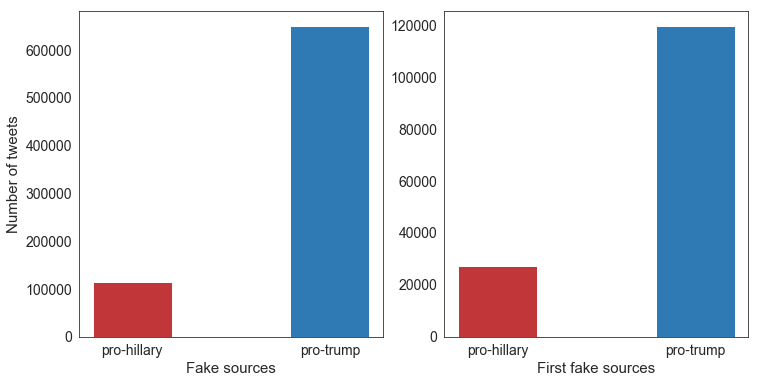

In [78]:
from collections import Counter
sns.set_style("white")
sns.color_palette("RdBu", n_colors=7)

count = Counter(staters_opinion)
print(count)

label = ["pro-hillary", "pro-trump"]
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.bar(1, count[0], color=sns.color_palette("RdBu")[0], width=0.2)
plt.bar(1.5, count[1], color=sns.color_palette("RdBu")[5], width=0.2)
plt.xticks([1, 1.5], label)
plt.xlabel('Fake sources', fontsize=15)
plt.ylabel('Number of tweets', fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
# plt.savefig("N of fake first sources.pdf", dpi=300)
# plt.show()
# plt.close()

count = Counter(first_opinion)
print(count)

label = ["pro-hillary", "pro-trump"]
plt.subplot(122)
plt.bar(1, count[0], color=sns.color_palette("RdBu")[0], width=0.2)
plt.bar(1.5, count[1], color=sns.color_palette("RdBu")[5], width=0.2)
plt.xticks([1, 1.5], label)
plt.xlabel('First fake sources', fontsize=15)
# plt.ylabel('N of fake sources', fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.savefig("fig/N of fake sources.pdf", dpi=300)
plt.show()
plt.close()


In [6]:
uids_of_IRA = set(json.load(open("data/IRA_match.json")).values())

In [12]:
from SQLite_handler import find_tweet

count_IRA_first = 0
count_IRA_starters = 0

for i, fake in tqdm(enumerate(url_tweets)):
    url = fake["url"]
    for j, t in enumerate(fake["tweets"]):
        if t["origin"]:
            if str(t["user_id"]) in uids_of_IRA:
                count_IRA_starters += 1
                if j == 0:
                    count_IRA_first += 1

count_IRA_first, count_IRA_starters

# url_tweets[-100000]["tweets"]
# json.dump(url_tweets, open("data/url_tweets.json", "w"), indent=2)

189620it [00:00, 217251.10it/s]


(6, 144)